In [47]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


# Pytorch device specific configuration
# Pytorch Gpu Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [48]:
# Generate data
def generate_data(n, batchSize=16):

    # generate data
    data = torch.randint(low=-10,high=11,size=(n,2)).float()

    # "labels"
    labels = torch.sum(data,axis=1,keepdim=True)
    # dataT = torch.randint(low=-10, high=11, size=(n, 2)).float()
    # labelsT = torch.sum(dataT, axis=1, keepdim=True)

    # # train test splits
    # train_data, test_data_temp, train_labels, test_labels_temp = train_test_split(
    #     dataT, labelsT, train_size=0.8
    # )
    # test_data, dev_data, test_labels, dev_labels = train_test_split(
    #     test_data_temp, test_labels_temp, train_size=0.5
    # )

    # # Pytorch datasets
    # train_dataT = TensorDataset(train_data, train_labels)
    # dev_dataT = TensorDataset(dev_data, dev_labels)
    # test_dataT = TensorDataset(test_data, test_labels)

    # # Dataloader objects
    # train_loader = DataLoader(
    #     train_dataT,
    #     batch_size=batchSize,
    #     shuffle=True,
    #     drop_last=True,
    #     generator=torch.Generator(device),
    # )
    # dev_loader = DataLoader(
    #     dev_dataT,
    #     batch_size=dev_dataT.tensors[0].shape[0],
    #     generator=torch.Generator(device),
    # )
    # test_loader = DataLoader(
    #     test_dataT,
    #     batch_size=test_dataT.tensors[0].shape[0],
    #     generator=torch.Generator(device),
    # )
    # return train_loader, dev_loader, test_loader
    return data, labels

In [49]:
# Function to create the class
def createTheModel():
    class Sum2NumbersClass(nn.Module):
        def __init__(self):
            super().__init__()

            # Input
            self.input = nn.Linear(2, 64)
            # Hidden Layers
            self.hidden1 = nn.Linear(64, 64)
            self.hidden2 = nn.Linear(64, 64)
            # Output Layers
            self.output = nn.Linear(64, 1)

        def forward(self, x):
            # Input
            x = F.relu(self.input(x))

            # Hidden Layers
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))

            # Output Layers
            return self.output(x)

    net = Sum2NumbersClass()

    # Loss Function
    lossFun = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.005)

    return net, lossFun, optimizer

In [50]:
# Test the model
net, lossFun, optimizer = createTheModel()
tempData = torch.tensor(100 * np.random.randn(100, 2)).float()
print(net(tempData))

tensor([[ 0.0631],
        [-1.2682],
        [-3.3036],
        [-0.2779],
        [ 2.3781],
        [ 0.3510],
        [ 2.5674],
        [ 0.2867],
        [ 2.5396],
        [ 6.7028],
        [ 1.5426],
        [ 5.6435],
        [ 1.8453],
        [ 3.3659],
        [ 2.5606],
        [ 0.1415],
        [ 1.7270],
        [ 1.1875],
        [ 0.1636],
        [-0.4047],
        [ 1.3971],
        [ 3.1022],
        [ 0.3220],
        [ 0.6665],
        [ 2.9424],
        [ 2.0379],
        [ 3.6696],
        [ 0.0773],
        [-0.8377],
        [-0.3169],
        [ 1.0632],
        [-3.5424],
        [ 3.1263],
        [ 1.7214],
        [ 2.2719],
        [ 5.4787],
        [ 3.7795],
        [ 8.1355],
        [-0.9920],
        [ 1.2592],
        [ 0.1553],
        [-0.5319],
        [ 1.0460],
        [ 2.3118],
        [ 0.5993],
        [ 0.5105],
        [-0.3675],
        [ 5.4026],
        [-2.2041],
        [ 4.0579],
        [ 6.8254],
        [-0.6927],
        [ 1.

In [54]:
# epochs
nEpochs = 30


def trainTheModel():
    # Model Instance
    net, lossFun, optimizer = createTheModel()

    # Initialize variables
    trainAcc = []
    testAcc = []
    losses = np.zeros(nEpochs)

    # The loop
    for epoch in range(nEpochs):
        # Model training mode
        net.train()

        # Batch loss and accuracy initialization
        batchLoss = []
        batchAcc = []

        # The batch loop
        for X, y in zip(data, labels):

            # Forward pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss and accuracy
            batchLoss.append(loss.cpu().item())
            batchAcc.append((100 * torch.mean((torch.abs(yHat - y) < 1).float())).cpu())

        # Batch loop end

        # Train Acc
        trainAcc.append(np.mean(batchAcc))
        losses[epoch] = np.mean(batchLoss)

        # Dev accuracy
        net.eval()
        # create brand new test data
        n=2000
        X = torch.randint(low=-10,high=11,size=(n,2)).float()
        y = torch.sum(X,axis=1,keepdim=True)
        with torch.no_grad():
            yHat = net(X)
        testAcc_tmp = (100 * torch.mean((torch.abs(yHat - y) < 1).float())).cpu()
        testAcc.append(testAcc_tmp)
    # The Loop End

    return trainAcc, testAcc, losses

In [55]:
# Model Experiment
n = 2000
nEpochs = 10
for i in range(10):
    print(f"######## Experiment: {i} ########")
    # Generate the data
    data, labels = generate_data(n)
    # New model instance
    net, lossFun, optimizer = createTheModel()
    # Train the model
    trainAcc, testAcc, losses = trainTheModel()
    # report accuracy
    print(
        "Model instance %s, final TRAIN/DEV/TEST accuracies: %g%%, %g%%"
        % (i + 1, trainAcc[-1], testAcc[-1])
    )

######## Experiment: 0 ########
Model instance 1, final TRAIN/DEV/TEST accuracies: 98.65%, 100%
######## Experiment: 1 ########
Model instance 2, final TRAIN/DEV/TEST accuracies: 99.55%, 68.7%
######## Experiment: 2 ########
Model instance 3, final TRAIN/DEV/TEST accuracies: 97.25%, 93.2%
######## Experiment: 3 ########
Model instance 4, final TRAIN/DEV/TEST accuracies: 98.6%, 100%
######## Experiment: 4 ########
Model instance 5, final TRAIN/DEV/TEST accuracies: 98.05%, 100%
######## Experiment: 5 ########
Model instance 6, final TRAIN/DEV/TEST accuracies: 97.25%, 100%
######## Experiment: 6 ########
Model instance 7, final TRAIN/DEV/TEST accuracies: 96%, 94.35%
######## Experiment: 7 ########
Model instance 8, final TRAIN/DEV/TEST accuracies: 98.8%, 100%
######## Experiment: 8 ########
Model instance 9, final TRAIN/DEV/TEST accuracies: 97.4%, 100%
######## Experiment: 9 ########
Model instance 10, final TRAIN/DEV/TEST accuracies: 98.4%, 100%


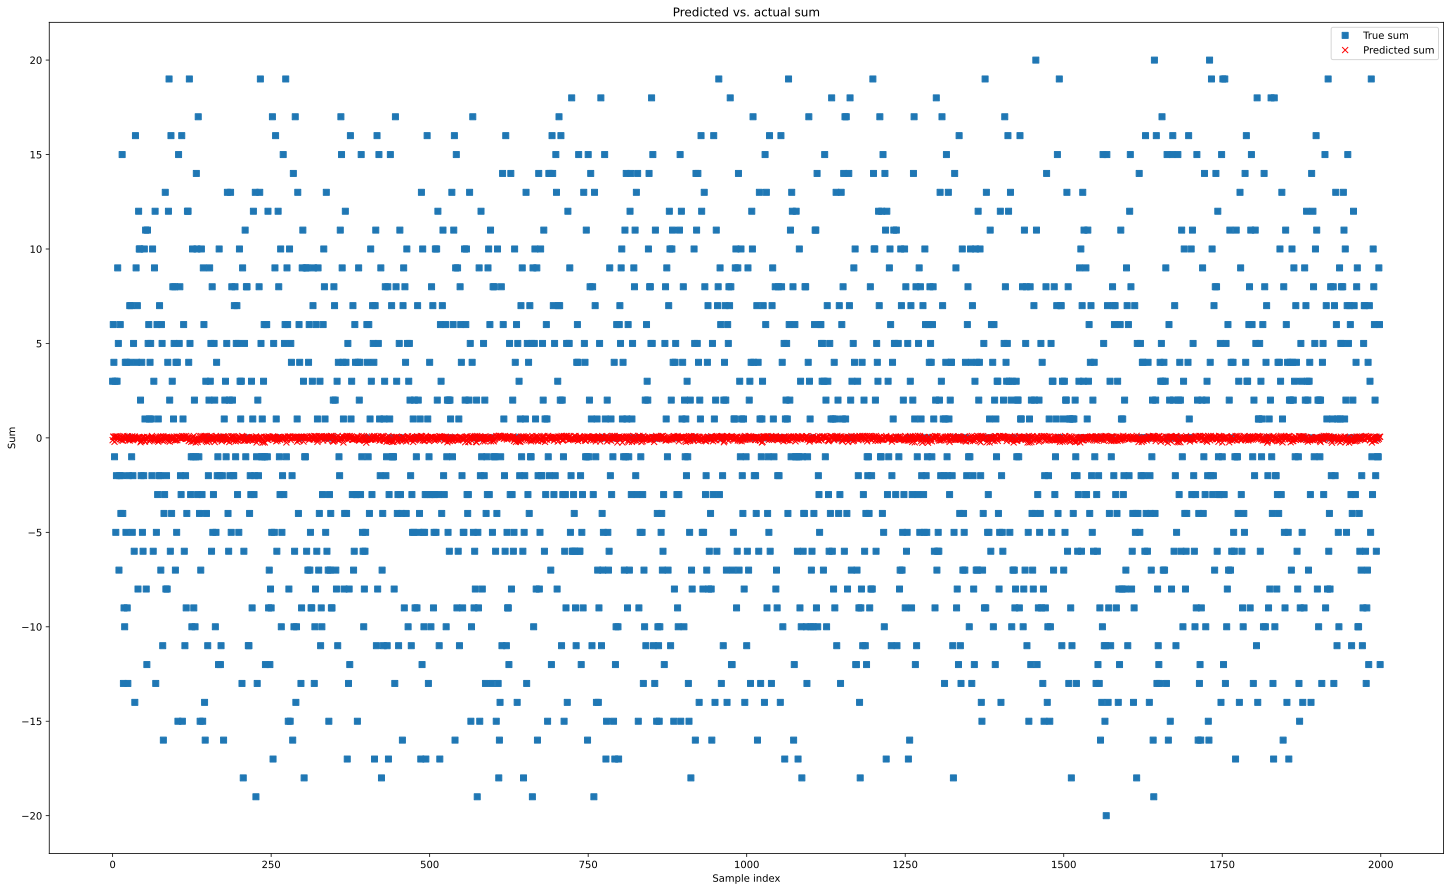

In [58]:
# some plots from the final model

X = torch.randint(low=-10, high=11, size=(n, 2)).float()
y = torch.sum(X, axis=1, keepdim=True)

# evaluate the model and compute accuracy
with torch.no_grad():
    yHat = net(X)
# print(f'Min: {torch.count_nonzero(X)}, Max: {X.size()}')

fig = plt.figure(figsize=(25, 15))
plt.plot(y.cpu(), "s")
plt.plot(yHat.cpu(), "rx")
plt.legend(["True sum", "Predicted sum"])
plt.xlabel("Sample index")
plt.ylabel("Sum")
plt.title(f"Predicted vs. actual sum")
plt.show()

In [ ]:
testAcc, yHat = testModePerformance(test_loader)
print(testAcc)

[tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
     